# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

`Признаки`
- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

`Целевой признак`
- Price — цена (евро)

## Подготовка данных

In [50]:
import pandas as pd                         # программная библиотека для обработки и анализа данных, поверх библиотеки NumPy
import numpy as np                          # поддержка многомерных массивов; поддержка высокоуровневых математических функций
import matplotlib.pyplot as plt             # библиотека для визуализации данных двумерной графикой

from sklearn.model_selection import train_test_split   # функция train_test_split для разделения датафрейма

from sklearn.tree import DecisionTreeRegressor              # алгоритм "деревом решений"
from sklearn.ensemble import RandomForestRegressor          # алгоритм "случайный лес"
from sklearn.linear_model import LinearRegression           # алгоритм "регрессия"
from lightgbm import LGBMRegressor                          # алгоритм «лёгкого градиентного бустинга»
from catboost import CatBoostRegressor                      # алгоритм «градиентного бустинга CatBoost»
from sklearn.model_selection import RandomizedSearchCV      #инпортируем инструмент кросс-валидации и обучения модели (рандом)


from sklearn.metrics import mean_squared_error         #импорт среднеквардатичного отклонения для оценки качества модели

from scipy.stats import randint

In [2]:
df = pd.read_csv('/datasets/autos.csv') #серверный путь к файлу

In [3]:
def data_description(dataframe):
    print('\033[1m' "Общий вид данных" '\033[0m')
    print(dataframe.head())
    print()
    print('\033[1m' "Общая информация о датафрейме и типе данных" '\033[0m')
    print(dataframe.info())
    print()
    print('\033[1m' "Описание данных в столбцах датафрейма" '\033[0m')
    print(round(dataframe.describe(),2))
    print()
    print('\033[1m' "Количество пропусков" '\033[0m')
    print(dataframe.isna().sum())
    print()
    print('\033[1m' "Количество дубликатов" '\033[0m')
    print(dataframe.duplicated().sum())
    print()
    print('\033[1m' "Количество дубликатов в %" '\033[0m')
    print(dataframe.duplicated().sum()/dataframe.shape[0]*100)

In [4]:
data_description(df)

Общий вид данных
           DateCrawled  Price VehicleType  RegistrationYear Gearbox  Power  \
0  2016-03-24 11:52:17    480         NaN              1993  manual      0   
1  2016-03-24 10:58:45  18300       coupe              2011  manual    190   
2  2016-03-14 12:52:21   9800         suv              2004    auto    163   
3  2016-03-17 16:54:04   1500       small              2001  manual     75   
4  2016-03-31 17:25:20   3600       small              2008  manual     69   

   Model  Kilometer  RegistrationMonth  FuelType       Brand NotRepaired  \
0   golf     150000                  0    petrol  volkswagen         NaN   
1    NaN     125000                  5  gasoline        audi         yes   
2  grand     125000                  8  gasoline        jeep         NaN   
3   golf     150000                  6    petrol  volkswagen          no   
4  fabia      90000                  7  gasoline       skoda          no   

           DateCreated  NumberOfPictures  PostalCode     

**Выводы:**

- Данные представлены преимущественно за 2016г.
- В данных есть:
    - выбросы, аномальные значения;
    - пропуски и нулевые значения;
    - дубликаты.
- В данных есть категориальные и количественные переменные.
- Дата в формате текста и необходимо преобразование.

## Предобрботка признаков

### Преобразование даты 

In [5]:
# переведем в формат даты 'date_time' для дальнейшей работы с переменной и добавим в датафрейм

df['DateCreated_date_time'] = pd.to_datetime(df['DateCreated'], format = '%Y-%m-%dT%H:%M:%S').dt.year 

In [6]:
df.head(3)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen,DateCreated_date_time
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57,2016
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50,2016
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46,2016


In [7]:
df = df.drop(columns='DateCreated')

In [8]:
df['DateCreated_date_time'].unique() # проверим на какие года приходятся регистрации объявлений

array([2016, 2015, 2014])

### Удаление признаков и дубликатов

In [9]:
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
# удалим признаки, которые не нужны для анализа

df = df.drop(columns=['PostalCode', 'NumberOfPictures','RegistrationMonth','LastSeen','DateCrawled'])

# фотографии - все нулевые значения
# DateCreated = DateCrawled
# RegistrationMonth - год регистрации "скажет больше"
# 'LastSeen' и 'PostalCode' опосредованно могут влиять на стоимость машины

In [11]:
df.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated_date_time
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN,2016
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes,2016
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN,2016


### Удаление строк с нулевой ценой

In [12]:
# оставим только те объявления, где цена больше 200 евро нуля
# на случай если продают авто на запчасти и не на ходу

df = df[df['Price']>= 200] 

### Обработка категориальных признаков

#### Заполнение пропусков

##### Заполнение NotRepaired, Model, Gearbox

In [13]:
df['NotRepaired'] = df['NotRepaired'].fillna('unknown') #мы не можем предполагать ремонты, заполняем "неизвестно"
df['Model'] = df['Model'].fillna('unknown') #мы не можем предполагать модель машины, заполняем "неизвестно"
df['Gearbox'] = df['Gearbox'].fillna('unknown') # у одной и той же модели авто может быть разная коробка передач

Определим уникальность значений в столбцах для выявления повторов, ошибок и пропусков.

In [14]:
columns_list = ['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']

for column in columns_list:
    print(f'Уникальные значения: {column}')
    print(df[column].unique())
    print()

Уникальные значения: VehicleType
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']

Уникальные значения: Gearbox
['manual' 'auto' 'unknown']

Уникальные значения: Model
['golf' 'unknown' 'grand' 'fabia' '3er' '2_reihe' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'other' 'c4' 'civic' 'transporter' 'punto' 'e_klasse'
 'clio' 'kadett' 'kangoo' 'one' 'fortwo' '1er' 'b_klasse' 'signum' 'astra'
 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156' 'escort'
 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo' 'focus' 'tt'
 'corsa' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' 'z_reihe' 'sportage'
 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3' 'almera'
 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus

##### Заполнение VehicleType

In [15]:
df[df['Brand'] == 'opel']           # срез датафрейма по бренду 
df[df['Model'] == 'meriva']         # срез датафрейма по модели авто

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated_date_time
22,2900,NaN,2018,manual,90,meriva,150000,petrol,opel,no,2016
1066,2250,NaN,2017,manual,90,meriva,150000,NaN,opel,unknown,2016
1238,2000,bus,2003,manual,87,meriva,150000,petrol,opel,no,2016
1284,2500,NaN,2016,unknown,0,meriva,125000,petrol,opel,unknown,2016
1404,9700,suv,2011,manual,101,meriva,30000,petrol,opel,unknown,2016
...,...,...,...,...,...,...,...,...,...,...,...
351921,3899,wagon,2004,auto,101,meriva,150000,petrol,opel,no,2016
352444,1500,other,2004,manual,101,meriva,150000,gasoline,opel,no,2016
352592,2800,bus,2005,manual,101,meriva,150000,gasoline,opel,no,2016
352803,6999,bus,2011,manual,110,meriva,125000,gasoline,opel,no,2016


На примере бренда "opel" и модели "meriva" мы видим, что тип кузова "wagon", "bus", "suv" и т.д. может быть различно указан пользователем. Не представляется возможным указать один тип кузова для комбинации "Brand" + "Model". Произведем замену на unknown.

In [16]:
df['VehicleType'] = df['VehicleType'].fillna('unknown') #у одного бренда и модели может быть разный тип кузова

##### Заполнение FuelType

Названия 'petrol' и 'gasoline' обозначают один и тот же продукт. Заменим все 'gasoline' на 'petrol', который более распространен.

In [17]:
df.loc[df['FuelType'] == "gasoline", 'FuelType'].count() # всего объектов с топливом "gasoline"

96829

In [18]:
df.loc[df['FuelType'] == "petrol", 'FuelType'].count() # всего объектов с топливом "petrol"

206709

In [19]:
df.loc[df['FuelType'] == "gasoline", 'FuelType'] = "petrol"

In [20]:
df.loc[df['FuelType'] == "petrol", 'FuelType'].count() # всего объектов с топливом "petrol" после замены

303538

In [21]:
df.groupby('FuelType').agg({'FuelType':'count'})

,FuelType
FuelType,
cng,548
electric,85
hybrid,225
lpg,5146
other,147
petrol,303538


В связи с тем, что тип топлива может отличаться для одной и той же марки автомобиля, есть два варианта замены пропущенных значений (NaN):
- замена всех пропусков на самый популярный тип топлива - petrol
    - Обычно, если топливо "особое", к примеру, газ, то продавец это указывает
    - Второе по популярности топливо 'lpg' составляет <2%.
    
    
- замена пропусков на 'unkown', что будет консервативным вариантом и отдельной веткой анализа при построении моделей.

**Вывод**: заменим пропуски по самому популярному типу топлива.

In [22]:
df.loc[df['FuelType'].isna(), 'FuelType'] = "petrol"

In [23]:
df.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
FuelType                 0
Brand                    0
NotRepaired              0
DateCreated_date_time    0
dtype: int64

### Обработка количественных признаков

In [24]:
df.head() # общий вид датафрейма, но обрабатывать будем только количественные признаки 

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated_date_time
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown,2016
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes,2016
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown,2016
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no,2016
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no,2016


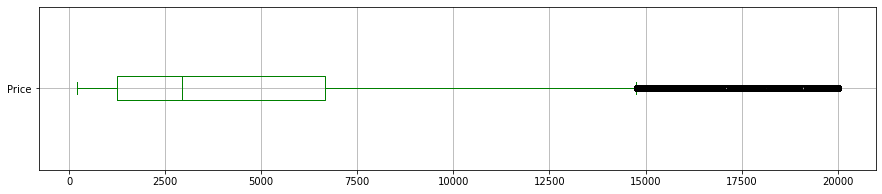

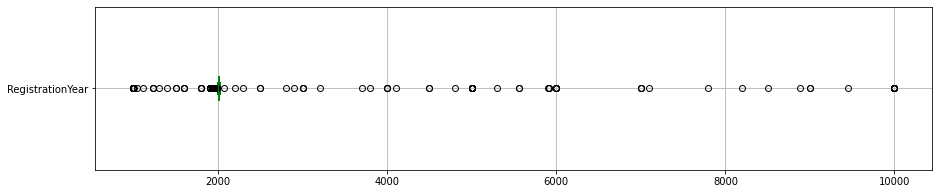

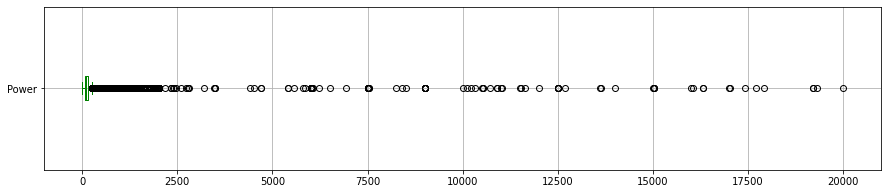

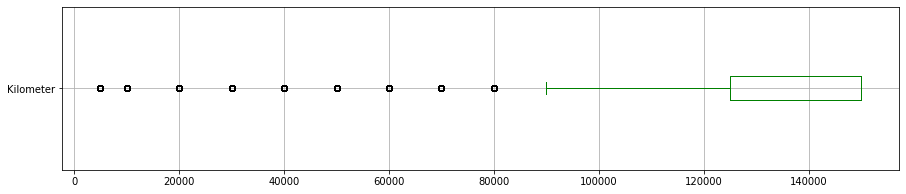

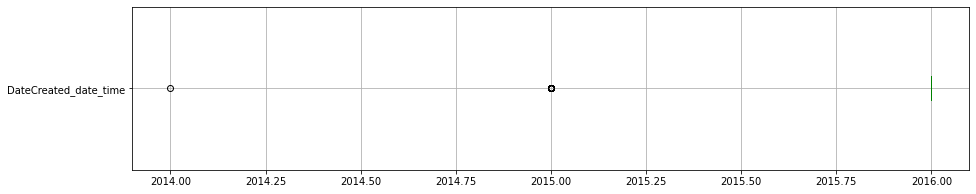

In [25]:
# построим диаграммы размаха для каждого столбца представленного цифрами

numeric_columns_list = ['Price','RegistrationYear','Power','Kilometer','DateCreated_date_time']

for numeric_column in numeric_columns_list:
    df[numeric_column].plot(
            kind='box',                         # тип графика
            grid=True,                          # отображение сетки
            figsize=(15,3),                     # размер графика
            color='green',                      # цвет ящика
            vert = 0                            # повернуть по горизонтали
        )
    plt.show()

- `Price`: по диаграмме размаха данные выглядят правдободобно, без значительных выбросов, нули были удалены.


- `RegistrationYear`: данные по году регистрации автомобилей с многочисленными выбросами от 1000 до 9999 года.


- `Power`: данные с многочисленными выбросами, мощность спортивных машин максимально 2000 л.с., не считая спец.технику:
    - вероятно ошибка в экспорте данных, надо уточнить у специалистов, предоставивших данные;
    - возможно другая размерность мощности двигателя и ошибка конвертации.
    

- `Kilometer`: по диаграмме размаха данные выглядят правдободобно, без значительных выбросов.


- `DateCreated_date_time`: данные за три года, преимущественно за 2016 год: практической пользы мало для машинного обучения.

##### Обработка RegistrationYear

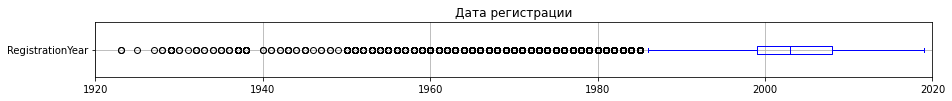

In [26]:
df['RegistrationYear'].plot(
        kind='box',
        title="Дата регистрации",
        grid=True,
        color='blue',
        xlim=(1920,2020),
        figsize=(15,1),
        vert = 0
)
plt.show()

In [27]:
display("Всего строк c аномалиями: 1) старше 1985 года 2) моложе даты публикации объявлений в 2016г.")

df.query('RegistrationYear <= 1985 or RegistrationYear >= 2017').shape[0] 

'Всего строк c аномалиями: 1) старше 1985 года 2) моложе даты публикации объявлений в 2016г.'

19058

In [28]:
# отфильтруем эти значения из основного датафрейма ввиду незначительного количества

df = df.query('1985 <= RegistrationYear <= 2017')

##### Обработка Power

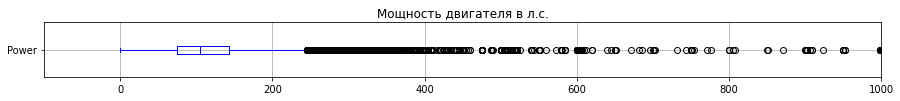

In [29]:
df['Power'].plot(
        kind='box',
        title="Мощность двигателя в л.с.",
        grid=True,
        color='blue',
        xlim=(-100,1000),
        figsize=(15,1),
        vert = 0
)
plt.show()

In [30]:
print("Всего строк со значениями мощности двигателя выше 1000 л.с.:", df.query('Power >= 1000').shape[0])

Всего строк со значениями мощности двигателя выше 1000 л.с.: 270


In [31]:
# отфильтруем эти значения из основного датафрейма ввиду незначительного количества
# максимальная цена 20 000 евро, что не соответствует машинам с большой мощностью двигателя (можно поставить лимит еще ниже)

df = df.query('Power <= 1000')

In [32]:
df.head(3)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired,DateCreated_date_time
0,480,unknown,1993,manual,0,golf,150000,petrol,volkswagen,unknown,2016
1,18300,coupe,2011,manual,190,unknown,125000,petrol,audi,yes,2016
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown,2016


In [33]:
# найдем значения мощности двигателя равной 0

print("Всего строк со значениями мощности двигателя НОЛЬ л.с.:",df[df['Power'] == 0].shape[0])

Всего строк со значениями мощности двигателя НОЛЬ л.с.: 31489


In [34]:
# заменим нулевые значения на медианную мощность для модели автомобиля (чтобы исключить выбросы)

df.loc[df['Power'] == 0, 'Power'] = df.groupby('Model')['Power'].transform('median')

In [35]:
print(round(df.describe(),0))

          Price  RegistrationYear     Power  Kilometer  DateCreated_date_time
count  327988.0          327988.0  327988.0   327988.0               327988.0
mean     4625.0            2004.0     120.0   128964.0                 2016.0
std      4507.0               6.0      53.0    36647.0                    0.0
min       200.0            1985.0       1.0     5000.0                 2014.0
25%      1250.0            1999.0      78.0   125000.0                 2016.0
50%      2950.0            2003.0     110.0   150000.0                 2016.0
75%      6600.0            2008.0     145.0   150000.0                 2016.0
max     20000.0            2017.0    1000.0   150000.0                 2016.0


In [36]:
# отфильтруем из основного датафрейма мощности двигателя ниже 25% персентиля

df = df.query('Power >= 78')

##### Обработка DateCreated_date_time

In [37]:
df = df.drop(columns='DateCreated_date_time') # удалим данный столбец

In [38]:
df.head() # вид датафрейма после всех преобразований

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
0,480,unknown,1993,manual,101.0,golf,150000,petrol,volkswagen,unknown
1,18300,coupe,2011,manual,190.0,unknown,125000,petrol,audi,yes
2,9800,suv,2004,auto,163.0,grand,125000,petrol,jeep,unknown
5,650,sedan,1995,manual,102.0,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109.0,2_reihe,150000,petrol,peugeot,no


In [39]:
df.shape # размер датафрейма после всех преобразований

(246153, 10)

## Обучение моделей

### Прямое кодирование

In [40]:
df_ohe = pd.get_dummies(df, drop_first = True) # переведем категориальные переменные в числовые

In [41]:
df_ohe.shape                                   # количество объектов и признаков + один целевой

(246153, 301)

### Разделение выборки

Требуется разделить весть датафрейм на 3 выборки:

- Обучающая (60% доля)
- Валидационная (20% доля)
- Тестовая (20% доля)

Разделим дата фрейм сначала на две части (60% и 40%), а затем вторую часть разделим пополам (20% и 20%). Тестовую выборку использовать не будем, "спрячем".

In [42]:
df_main, df_40 = train_test_split(df_ohe, test_size=0.40, random_state=42)
df_valid, df_test = train_test_split(df_40, test_size=0.50, random_state=42)

In [43]:
#проверим размерности датафреймов

print('Размер обучающего датафрейма:', df_main.shape)
print('Размер валидационного датафрейма:', df_valid.shape)
print('Размер тестового датафрейма:', df_test.shape)

Размер обучающего датафрейма: (147691, 301)
Размер валидационного датафрейма: (49231, 301)
Размер тестового датафрейма: (49231, 301)


In [44]:
#Разделим датафреймы на "признаки" (features) и "целевой признак" (target)

features_train = df_main.drop('Price', axis=1)   #обучающий датафрейм по "признакам"
target_train = df_main['Price']                  #обучающий датафрейм по "целевому признаку"

features_valid = df_valid.drop('Price', axis=1)
target_valid = df_valid['Price']

features_test = df_test.drop('Price', axis=1)
target_test = df_test['Price']

## Анализ моделей

### Алгоритм - дерево решений

In [53]:
%%time

# создадим цикл с перебором гипперпараметров:
# - глубина дерева / max_depth
# - min_samples_split -  гиперпараметр запрещает создавать узлы, в которые попадает слишком мало объектов обучающей выборки

best_tree_model = None
#best_tree_depth = 0
#best_tree_split = 0
best_tree_rmse = 10000

for depth_tree in range(20,50,5):
    for samples_split in range(35,65,5):
        model_tree = DecisionTreeRegressor(random_state=42,
                                               max_depth = depth_tree,
                                               min_samples_split = samples_split
                                               )
            
        model_tree.fit(features_train, target_train)
            
        predictions_valid_tree = model_tree.predict(features_valid)
            
        rmse_tree = mean_squared_error(target_valid, predictions_valid_tree)**0.5
            
        if rmse_tree < best_tree_rmse:
            best_tree_model = model_tree
            best_tree_rmse = rmse_tree
   
print(f'Лучшая модель "дерево решений"')
print(best_tree_model)
print()
print(f'RMSE "дерево решений": {round(best_tree_rmse,5)}')


Лучшая модель "дерево решений"
DecisionTreeRegressor(max_depth=30, min_samples_split=55, random_state=42)

RMSE "дерево решений": 1917.49055
CPU times: user 3min 13s, sys: 3.69 s, total: 3min 16s
Wall time: 3min 31s


**Вывод:** Лучшая модель "дерево решений" ошибается в прогнозе в среднем на **1917** евро, что достаточно много для медианной цены в 2600 евро.

### Алгоритм - случайный лес

In [46]:
%%time

# создадим цикл с перебором гипперпараметров:
# - глубина дерева / max_depth
# - количество деревьев в лесу / n_estimators

best_forest_model = None
#best_forest_estimator = 0
#best_forest_depth = 0
best_forest_rmse = 10000

for forest_estimator in range(70,85,5):
    for forest_depth in range(20,35,5):
        model_forest= RandomForestRegressor(random_state=42,
                                               n_estimators = forest_estimator,
                                               max_depth = forest_depth
                                               )
            
        model_forest.fit(features_train, target_train)
            
        predictions_valid_forest = model_forest.predict(features_valid)
            
        rmse_forest = mean_squared_error(target_valid, predictions_valid_forest)**0.5
            
        if rmse_forest < best_forest_rmse:
            best_forest_model = model_forest
            best_forest_rmse = rmse_forest
   
print(f'Лучшая модель "случайный лес"')
print(best_forest_model)
print()
print(f'RMSE "случайный лес": {round(best_forest_rmse,5)}')


Лучшая модель "случайный лес"
RandomForestRegressor(max_depth=30, n_estimators=80, random_state=42)

RMSE "случайный лес": 1742.1212
CPU times: user 36min 21s, sys: 4.18 s, total: 36min 25s
Wall time: 37min 1s


**Вывод:**
- Лучшая модель "случайный лес" ошибается в прогнозе в среднем на **1742** евро, что достаточно много для медианной цены в 2600 евро.
- Лучший результат для базовых моделей, однако, время обучения и прогнозирования занимает очень продолжительное время - час.
    - Поиск оптимального значения "n_estimators" отложим, т.к. интерации занимают много времени.

### Алгоритм - линейная регрессия

In [47]:
%%time

model_linear = LinearRegression()

model_linear.fit(features_train, target_train)
            
predictions_valid_linear = model_linear.predict(features_valid)
            
rmse_linear = mean_squared_error(target_valid, predictions_valid_linear)**0.5

print(f'Модель "линейная регрессия"')
print(model_linear)
print()
print(f'RMSE "линейная регрессия": {round(rmse_linear,5)}')

Модель "линейная регрессия"
LinearRegression()

RMSE "линейная регрессия": 2631.82686
CPU times: user 9.29 s, sys: 9.64 s, total: 18.9 s
Wall time: 19.7 s


**Вывод:** Лучшая модель "линейная регрессия" ошибается в прогнозе в среднем на **2632** евро, что много для медианной цены в 2600 евро.

### Алгоритм - LightGBM - «лёгкий градиентный бустинг»

In [59]:
%%time

# создадим цикл с перебором гипперпараметров:
# - скорости обучения / learning_rate 
# - количество деревьев в лесу / n_estimators 

best_lgbm_model = None
#best_lgbm_estimator = 0
#best_lgbm_rate = 0
best_lgbm_rmse = 10000

lgbm_rate_list = [0.3, 0.4, 0.5]

for lgbm_rate in lgbm_rate_list:
    for lgbm_estimator in range(100,500,100):
        model_lgbm = LGBMRegressor(random_state=42,
                                   learning_rate = lgbm_rate,
                                   n_estimators = lgbm_estimator
                                   )
            
        model_lgbm.fit(features_train, target_train)
            
        predictions_valid_lgbm = model_lgbm.predict(features_valid)
            
        rmse_lgbm = mean_squared_error(target_valid, predictions_valid_lgbm)**0.5
            
        if rmse_lgbm < best_lgbm_rmse:
            best_lgbm_model = model_lgbm
            best_lgbm_rmse = rmse_lgbm
   
print(f'Лучшая модель "LightGBM"')
print(best_lgbm_model)
print()
print(f'RMSE "LightGBM": {round(best_lgbm_rmse,5)}')


Лучшая модель "LightGBM"
LGBMRegressor(learning_rate=0.3, n_estimators=400, random_state=42)

RMSE "LightGBM": 1707.42967
CPU times: user 2h 57min 36s, sys: 1min 27s, total: 2h 59min 3s
Wall time: 3h 4min 57s


**Вывод:** Лучшая модель "LightGBM" ошибается в прогнозе в среднем на **1707** евро, что является вторым результатом по метрике RMSE и самым продолжительным циклом анализа данных.

### Алгоритм - CatBoost - «градиентный бустинг»

In [63]:
%%time

# создадим цикл с перебором гипперпараметров:
# - скорости обучения / learning_rate 
# - количество деревьев в лесу / n_estimators 

best_cat_model = None
best_cat_iterations = 0
best_cat_rate = 0
best_cat_rmse = 100000

cat_rate_list = [0.2, 0.3, 0.4, 0.5]

for cat_rate in cat_rate_list:
    for cat_iteration in range(100,600,100):
        model_cat = CatBoostRegressor(random_state=42,
                                   learning_rate = cat_rate,
                                   iterations = cat_iteration,
                                   verbose = False
                                   )
            
        model_cat.fit(features_train, target_train)
            
        predictions_valid_cat = model_cat.predict(features_valid)
            
        rmse_cat = mean_squared_error(target_valid, predictions_valid_cat)**0.5
            
        if rmse_cat < best_cat_rmse:
            best_cat_model = model_cat
            best_cat_rmse = rmse_cat
            best_cat_iterations = cat_iteration
            best_cat_rate = cat_rate
   
print(f'Лучшая модель "CatBoost"')
print(best_cat_model)
print("Количество итераций:", best_cat_iterations)
print("Скорость обучения:", best_cat_rate)
print()
print(f'RMSE "CatBoost": {round(best_cat_rmse,5)}')

Лучшая модель "CatBoost"
Количество итераций: 500
Скорость обучения: 0.5

RMSE "CatBoost": 1729.97675
CPU times: user 3min 13s, sys: 1.01 s, total: 3min 14s
Wall time: 10min 50s


### Кросс-валидация RandomizedSearchCV для обучающей выборки

In [56]:
param_grid = {'n_estimators': randint(100, 500),
              'learning_rate': np.linspace(0.3,0.8,10),
              'max_depth': randint(3, 15)
             }

random_search = RandomizedSearchCV(CatBoostRegressor(loss_function="RMSE",random_state=42,verbose=False),
                                   param_grid,
                                   scoring='neg_root_mean_squared_error',
                                   random_state=42,
                                   cv=5,
                                   n_jobs=-1
                                  )

random_search.fit(features_train, target_train)

RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7fe7428ad730>,
                   n_jobs=-1,
                   param_distributions={'learning_rate': array([0.3       , 0.35555556, 0.41111111, 0.46666667, 0.52222222,
       0.57777778, 0.63333333, 0.68888889, 0.74444444, 0.8       ]),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe7426264f0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fe7428ad190>},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [57]:
print(random_search.best_score_)

print(random_search.best_params_)

-1712.0987972356168
{'learning_rate': 0.3, 'max_depth': 14, 'n_estimators': 413}


## Результаты

In [64]:
datas = [
    [best_tree_rmse, best_forest_rmse, rmse_linear, best_lgbm_rmse, best_cat_rmse],
    ['3min 31s', '37min 1s', '19.7 s', '3h 4min 57s', '10min 50s']
]

columns_title = ["Tree", "RandomForest", "LinearRegres", "LGBM", "CatBoost"]

row_indexes = ['RMSE','Wall time']

summary = pd.DataFrame(data=datas, columns=columns_title, index=row_indexes)

In [65]:
summary

,Tree,RandomForest,LinearRegres,LGBM,CatBoost
RMSE,1917.490548,1742.121199,2631.826856,1707.429673,1729.976755
Wall time,3min 31s,37min 1s,19.7 s,3h 4min 57s,10min 50s


Вывод:
- Лучший результат дает «лёгкий градиентный бустинг» - LightGBM, однако, время анализа самое большое, что не отвечает целям заказчика по скорости обучения и предсказания.
- Второй результат по метрике качества RMSE у "CatBoost" и лучший баланс по результату и времени выполнения анализа.
- "CatBoost" будет использован для тестовой выборки.

## Анализ на тестовой выборке

In [66]:
predictions_test_cat = best_cat_model.predict(features_test)

rmse_cat_test = mean_squared_error(target_test, predictions_test_cat)**0.5

print(f'RMSE "CatBoost" на тестовой выборке: {round(rmse_cat_test,5)}')

RMSE "CatBoost" на тестовой выборке: 1746.03884


**Вывод:**

`Результаты на тестовой выборке сопоставимы с валидационной выборкой. Указанная модель принимается в качестве лучшей для рекомендации заказчику.`

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей